In [1]:
# import packages needed for entire model

import tensorflow as tf
from keras import layers, regularizers, metrics
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import pandas as pd
from sklearn.model_selection import train_test_split, ShuffleSplit
import numpy as np
import matplotlib.pyplot as plt
from keras.backend import softsign
import shutil
import random
import sys
import h5py
from google.colab import drive
terminal = sys.stdout
# mount to google drive in order to pull data file
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Option 1 for running Network
# Takes Random Data of a specified size
subsetSize = 10000
validationSize = 2000
splicingVal = 11
numOutputs = int(220/splicingVal)

# import data file, splice data, split into testing and training data
file = "/content/drive/My Drive/Colab Notebooks/dataset_comp_image_spectra.h5"
hf = h5py.File(file, 'r')
imgs = hf['images'][()]
spectra = hf['spectra'][()]
atfrac = np.transpose(hf['atfrac'][()])
z = list(zip(imgs, spectra, atfrac))
badIndices = [i for i, each in enumerate(imgs) if np.sum(each[16:48][16:48]) > 2450 or round(np.sum(atfrac[i])) == 0]
badIndices.reverse()
for index in badIndices:
  del z[index]
random.shuffle(z)
imgs, spectra, atfrac = zip(*z)
spectra = np.array([x[::splicingVal] for x in spectra])
atfracNN = np.array(list(atfrac[0:subsetSize]))
imgsNN = list(imgs[0:subsetSize])
spectraNN = list(spectra[0:subsetSize])
#atfrac_valid = np.array(list(atfrac[subsetSize:subsetSize+validationSize]))
#x_valid = np.array(list(imgs[subsetSize:subsetSize+validationSize]))
#y_valid = np.array(list(spectra[subsetSize:subsetSize+validationSize]))
del imgs, spectra, atfrac, z
imgsNNcopy = list(imgsNN)
spectraNNcopy = list(spectraNN)

In [7]:
#run on second go
imgsNN = list(imgsNNcopy)
spectraNN = list(spectraNNcopy) 

In [8]:
def nonZeroInList(arr):
  return [[atfrac_keys[i], i, ele] for i, ele in enumerate(arr) if ele > 0.0]

atfrac_keys = hf['atfrac_keys']
nonZeroList = [nonZeroInList(each) for each in atfracNN]

oxideIndices = []
for i, nonZero in enumerate(nonZeroList):
  for info in nonZero:
    currMetal = info[1]
    for otherInfo in nonZero:
      otherMetal = otherInfo[1]
      if currMetal in [7] and otherMetal in [10] and otherMetal != currMetal:
        oxideIndices.append(i)
print(len(oxideIndices))
oxideIndices.reverse()
x_valid = []
y_valid = []
for index in oxideIndices[0:int(len(oxideIndices)*.1)]: 
  x_valid.append(imgsNN[index])
  y_valid.append(spectraNN[index])
  del imgsNN[index], spectraNN[index] 
#uncomment on second run
for index in oxideIndices[int(len(oxideIndices)*.1):]:
  del imgsNN[index], spectraNN[index]
imgsNN, spectraNN, x_valid, y_valid = np.array(imgsNN), np.array(spectraNN), np.array(x_valid), np.array(y_valid)

3628


In [9]:
# Current Neural Network Model function

def get_conv_model_normal():

    model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(.1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(units=numOutputs, activation = 'sigmoid')])
    model.summary()
    adamOpti = tf.keras.optimizers.Adam(lr = 0.001)
    model.compile(optimizer= adamOpti, loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

In [10]:
# Running Neural Network with averaging Ensemble, including early stopping

# Define number of networks, batches, and epochs 

numNetworks = 5
epochs = 50
batch_size = 32

# Run Neural Network for the desired number of networks in the ensemble (numNetworks)


modelList = []
historyList= []

data = ShuffleSplit(n_splits=numNetworks, random_state=0, test_size=0.20, train_size=None)
data.get_n_splits(imgsNN, spectraNN)
for train_index, test_index in data.split(imgsNN, spectraNN):
  x_train, x_test = imgsNN[train_index], imgsNN[test_index]
  y_train, y_test = spectraNN[train_index], spectraNN[test_index]
  normal_model = get_conv_model_normal()
  early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
  normal_history = normal_model.fit(x_train, y_train, batch_size = batch_size,
                epochs = epochs, validation_data = (x_test, y_test), verbose = 1,
                callbacks= [early_stopping])
  modelList.append(normal_model)
  historyList.append(normal_history)


# Create predictions based on results of the neural network and ensemble 

def makePredictionsList(modelList, data):
  return [model.predict(data) for model in modelList]

# Create the geometric average of the output spectra from the predicted values from the ensemble

def ensemblePredictGeoAverage(predictList, ele):
  numNetworks = len(predictList)
  prediction = 1
  for predict in predictList:
    prediction *= np.abs(predict[ele])
  return prediction**(1/numNetworks)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 62, 62, 64)        1792      
                                                                 
 dense_20 (Dense)            (None, 62, 62, 256)       16640     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 31, 31, 256)      0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 31, 31, 256)       0         
                                                                 
 flatten_5 (Flatten)         (None, 246016)            0         
                                                                 
 dense_21 (Dense)            (None, 256)               62980352  
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


160/160 [==============================] - 4s 24ms/step - loss: 0.0153 - mean_squared_error: 0.0153 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 2/50
160/160 [==============================] - 3s 22ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 3/50
160/160 [==============================] - 3s 21ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 4/50
160/160 [==============================] - 3s 21ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 5/50
160/160 [==============================] - 3s 21ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 6/50
160/160 [==============================] - 3s 22ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 7/50
160/160 [=============

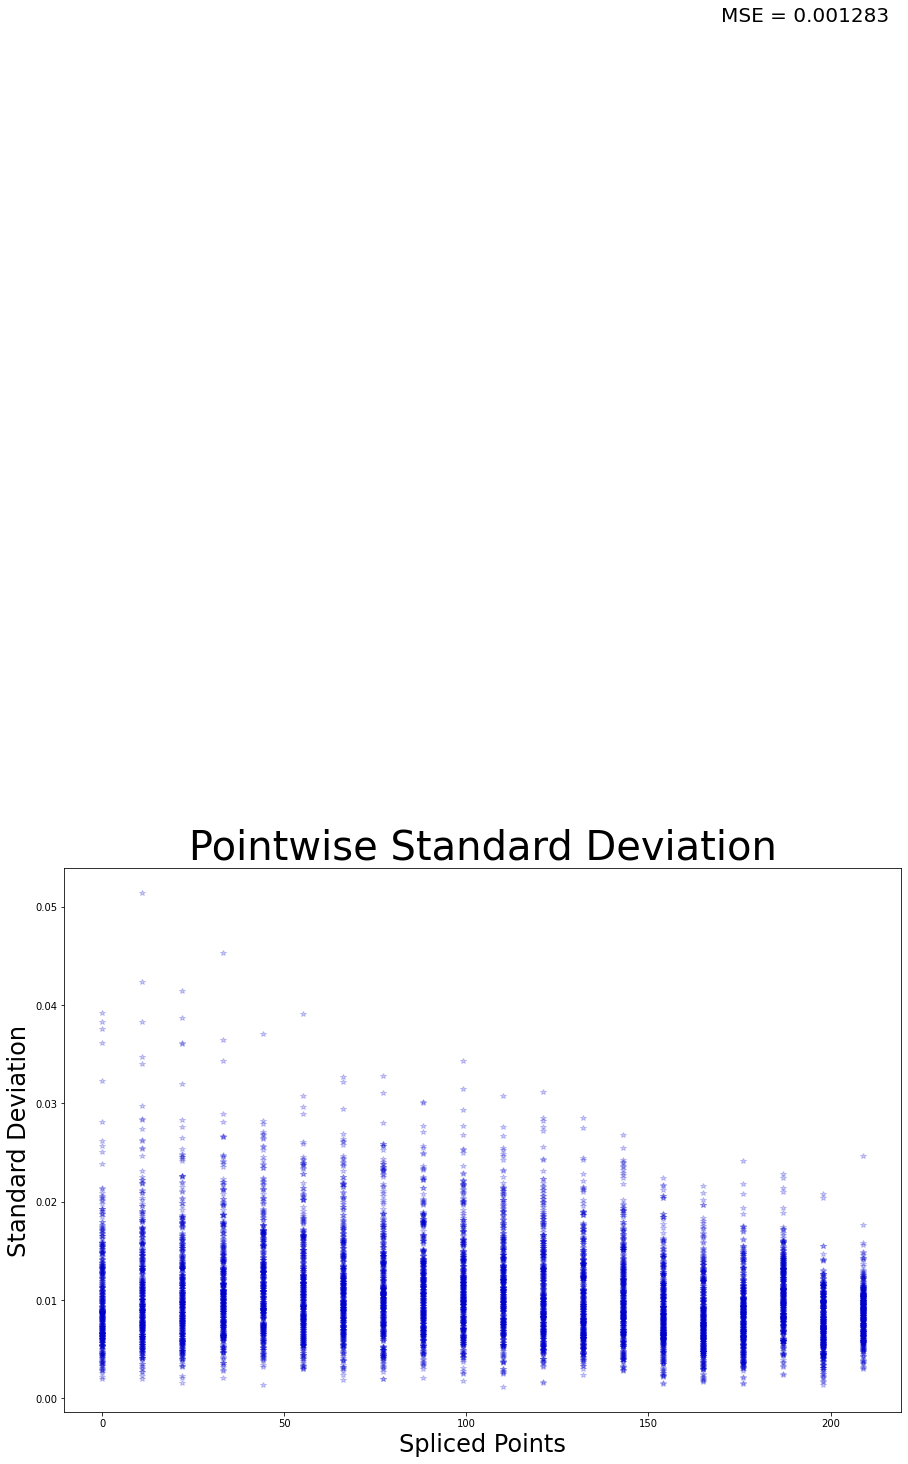

In [6]:
# ------ RUN 1 --------

def ensembleUncertainty(predictList, ele):
  newPredict = np.transpose(predictList, (1, 2, 0))
  return np.array([np.std(output) for output in newPredict[ele]])

x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_valid)
y_pred = np.array([ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))])
UQ1 = np.array([ensembleUncertainty(predictList, ele) for ele in range(len(x_valid))])

fig = plt.figure(figsize=(15, 10))
for i in range(len(x_valid)):
  plt.plot(x, UQ1[i], '*', color = 'mediumblue', alpha = 0.2)
plt.text(170, 0.14, f"MSE = {round(float(np.mean((y_valid-y_pred)**2)), 6)}", fontsize = 20)
plt.title('Pointwise Standard Deviation', fontsize = 40)
plt.xlabel('Spliced Points', fontsize = 24)
plt.ylabel('Standard Deviation', fontsize = 24)
plt.savefig('PointWiseSTD.jpg')
plt.show()

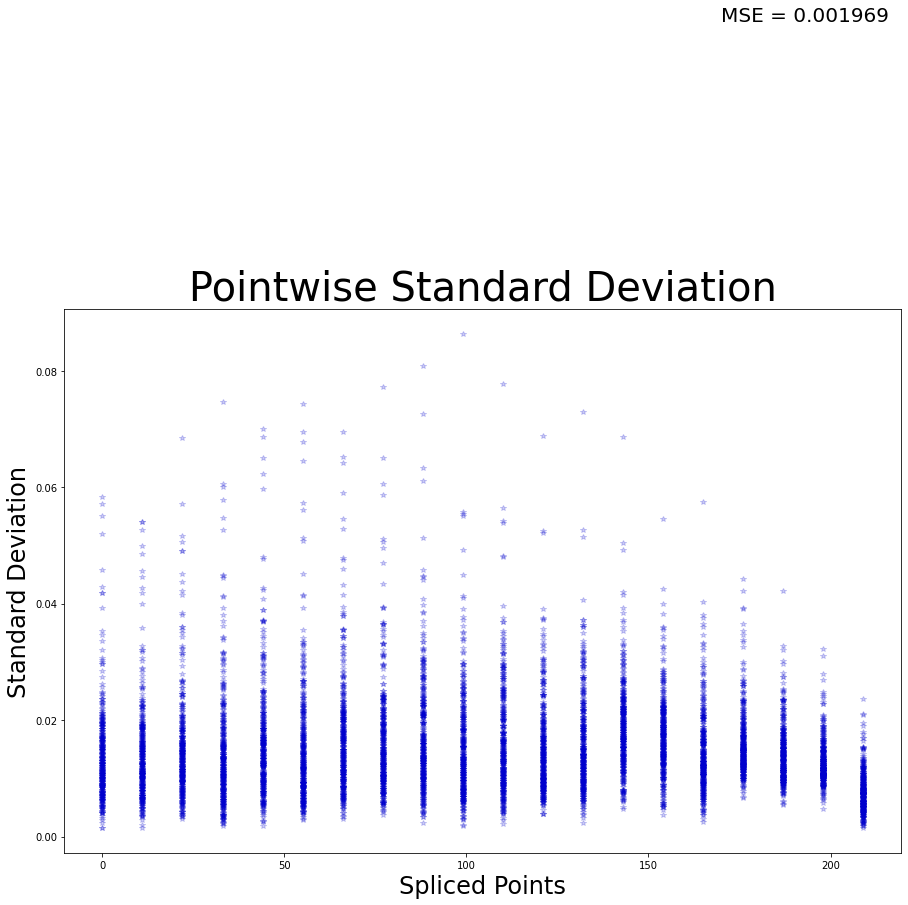

In [11]:
# ------ RUN 2 --------

def ensembleUncertainty(predictList, ele):
  newPredict = np.transpose(predictList, (1, 2, 0))
  return np.array([np.std(output) for output in newPredict[ele]])

x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_valid)
y_pred = np.array([ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_valid))])
UQ2 = np.array([ensembleUncertainty(predictList, ele) for ele in range(len(x_valid))])

fig = plt.figure(figsize=(15, 10))
for i in range(len(x_valid)):
  plt.plot(x, UQ2[i], '*', color = 'mediumblue', alpha = 0.2)
plt.text(170, 0.14, f"MSE = {round(float(np.mean((y_valid-y_pred)**2)), 6)}", fontsize = 20)
plt.title('Pointwise Standard Deviation', fontsize = 40)
plt.xlabel('Spliced Points', fontsize = 24)
plt.ylabel('Standard Deviation', fontsize = 24)
plt.savefig('PointWiseSTD.jpg')
plt.show()

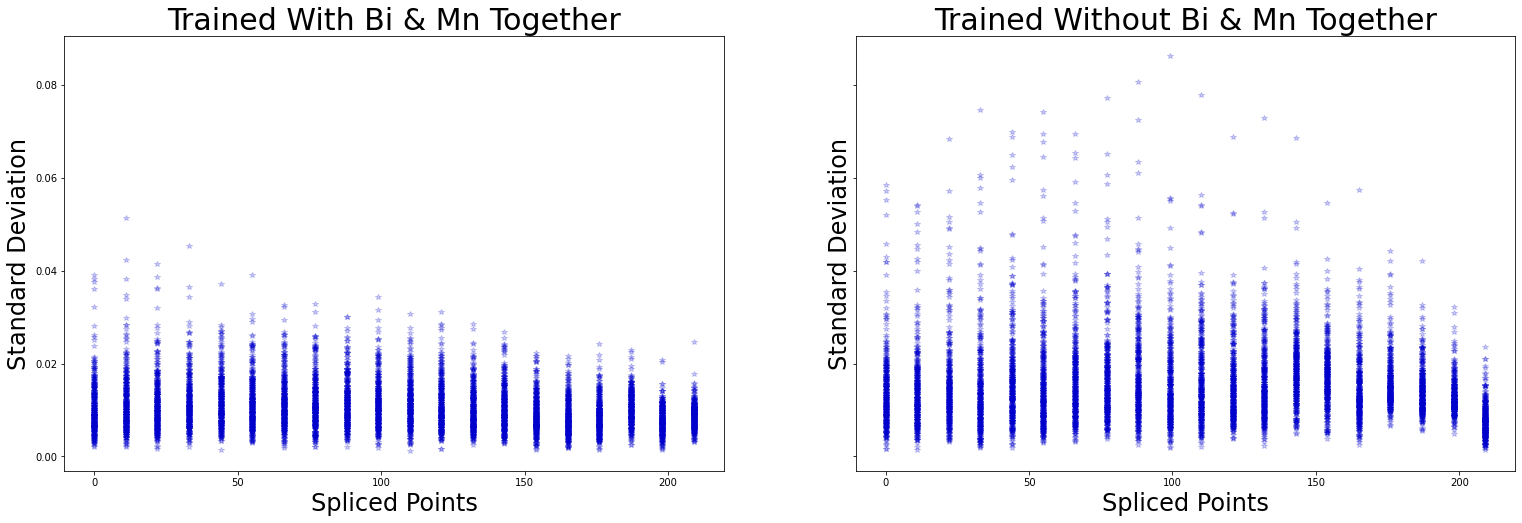

In [18]:
fig, axs = plt.subplots(1, 2, sharey = True, figsize = (26,8))
for i in range(len(x_valid)):
  axs[0].plot(x, UQ1[i], '*', color = 'mediumblue', alpha = 0.2)
  axs[0].set_title('Trained With Bi & Mn Together', fontsize = 30)
  axs[1].plot(x, UQ2[i], '*', color = 'mediumblue', alpha = 0.2)
  axs[1].set_title('Trained Without Bi & Mn Together', fontsize = 30)

for ax in axs:
#  ax.set_title('--CHANGE--')
  # left is with bismuth and manganese in the same combination
  # right is excluding bismuth and manganese in the same combination
  # 

  ax.set_xlabel('Spliced Points', fontsize = 24)
  ax.set_ylabel('Standard Deviation', fontsize = 24)
#fig.suptitle('--CHANGE--')

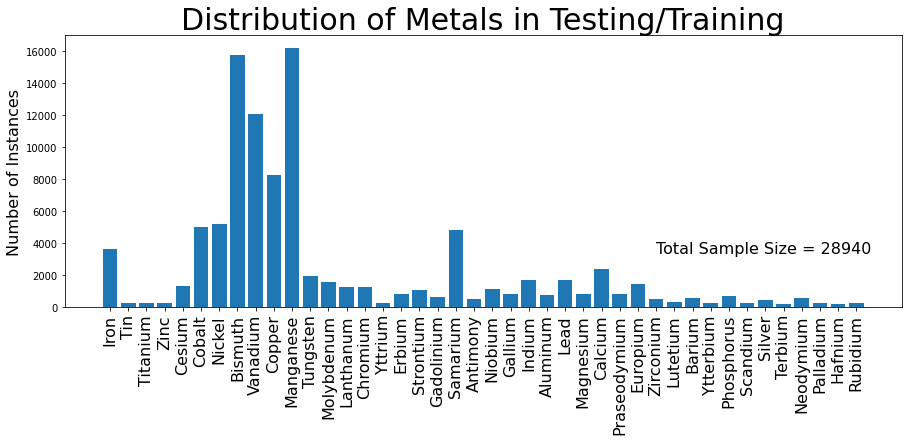

In [ ]:
# Use with either option, more applicable for Option 2
# BOTTOM GETS CUT OFF MUST MANUALLY SAVE IMAGE IF YOU WANT IT

def nonZeroInList(arr):
  return [[atfrac_keys[i], i, ele] for i, ele in enumerate(arr) if ele > 0.0]

atfrac_keys = hf['atfrac_keys']
nonZeroList = [nonZeroInList(each) for each in atfracNN]
dic = {}
for i in range(42):
  dic[str(i)] = 0
for nonZero in nonZeroList:
  for info in nonZero:
    metal = info[1]
    dic[str(metal)] += 1
#for i in range(42):
#  print(i, dic[str(i)])
f, axs = plt.subplots(figsize = (15,5))
oxides = 'Iron, Tin, Titanium, Zinc, Cesium, Cobalt, Nickel, Bismuth, Vanadium, Copper, Manganese, Tungsten, Molybdenum, Lanthanum, Chromium, Yttrium, Erbium, Strontium, Gadolinium, Samarium, Antimony, Niobium, Gallium, Indium, Aluminum, Lead, Magnesium, Calcium, Praseodymium, Europium, Zirconium, Lutetium, Barium, Ytterbium, Phosphorus, Scandium, Silver, Terbium, Neodymium, Palladium, Hafnium, Rubidium'
oxides = oxides.split(', ') 
axs.bar(oxides, dic.values())
axs.set_xticklabels(oxides, rotation = 90, fontsize = 16)
axs.set_ylabel('Number of Instances', fontsize = 16)
axs.set_title('Distribution of Metals in Testing/Training', fontsize = 30)
axs.text(30, 3400, f"Total Sample Size = {len(imgsNN)}", fontsize = 16)

plt.show()

f.savefig('SpecificData.jpg')